### Plotting the alignability of centrolign with respect to distance from the CDR

In [28]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt


In [27]:
# Function to read in CDR distance bed files to dataframe 
def read_bedtools_subset(bed_dir):
    dfs = []

    bed_files = glob.glob(os.path.join(bed_dir, "*.bed"))

    for bed in bed_files:
        df = pd.read_csv(
            bed,
            sep="\t",
            header=None,
            usecols=[0, 1, 2, 3, 4, 6, 14],  
            names=["contig", "start", "end", "prop_aligned", "n_pairs", "cdr_start", "dist_to_cdr"]
        )
        df["source_file"] = os.path.basename(bed)  # optional
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

### Chr 11 test case 

### Subsetting to pairs with dist < 0.4 

In [18]:
bed_dir = "/private/groups/patenlab/mira/windowed_alignment_beds_asm_coords_dist0.4/CDR_distance"
df = read_bedtools_subset(bed_dir)

print(df.head())
print(df.shape)


                 contig     start       end  prop_aligned  n_pairs  cdr_start  \
0  HG02514#2#CM098752.1  50767034  50767084      1.000000       26         -1   
1  HG02514#2#CM098752.1  50767084  50767134      1.000000       26         -1   
2  HG02514#2#CM098752.1  50767134  50767184      1.000000       26         -1   
3  HG02514#2#CM098752.1  50767184  50767234      1.000000       26         -1   
4  HG02514#2#CM098752.1  50767234  50767284      0.999231       26         -1   

   dist_to_cdr                                source_file  
0           -1  HG02514.2.windowed_alignment.CDR_dist.bed  
1           -1  HG02514.2.windowed_alignment.CDR_dist.bed  
2           -1  HG02514.2.windowed_alignment.CDR_dist.bed  
3           -1  HG02514.2.windowed_alignment.CDR_dist.bed  
4           -1  HG02514.2.windowed_alignment.CDR_dist.bed  
(7898912, 8)


Distance range: -3242686 to 3951887


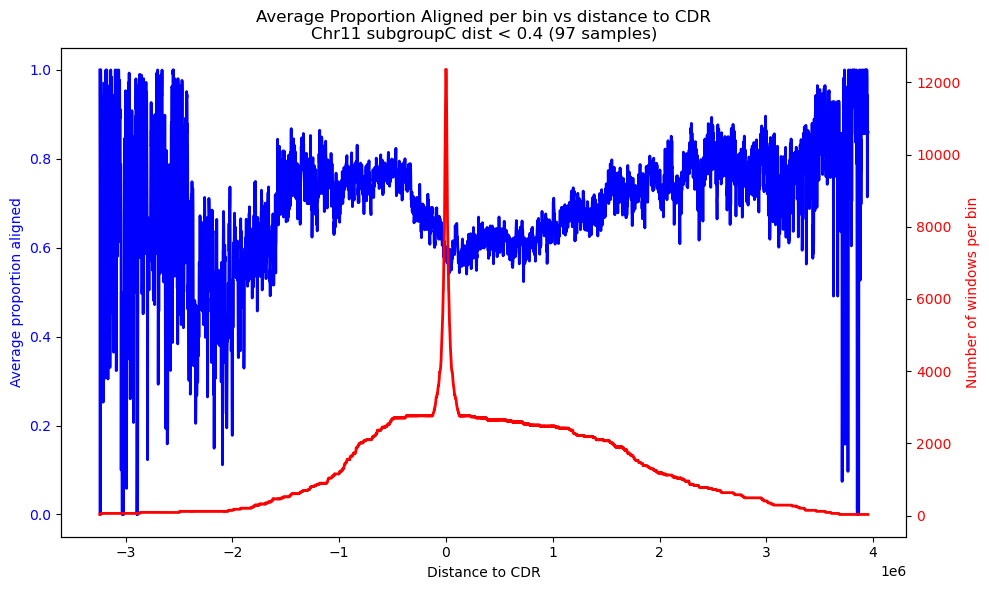

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter for no CDR intersections found
df_plot = df[df["cdr_start"] != -1].copy()

# Calculate number of unique contigs
num_unique_contigs = df_plot["contig"].nunique()

# Determine dynamic range from data
min_dist = df_plot["dist_to_cdr"].min()
max_dist = df_plot["dist_to_cdr"].max()
print(f"Distance range: {min_dist} to {max_dist}")

# Define bins dynamically
num_bins = 5000
bins = np.linspace(min_dist, max_dist, num_bins + 1)

# Bin the distances
df_plot["bin"] = pd.cut(
    df_plot["dist_to_cdr"],
    bins=bins,
    include_lowest=True
)

# Aggregate per bin
bin_stats = (
    df_plot
    .groupby("bin", observed=True)
    .agg(
        prop_aligned_mean=("prop_aligned", "mean"),
        n_rows=("dist_to_cdr", "size")  # number of rows per bin
    )
    .reset_index()
)

# Bin centers for plotting
bin_stats["bin_center"] = bin_stats["bin"].apply(lambda x: x.mid)

# Optionally exclude dist=0 bin for secondary axis
zero_bin_mask = bin_stats["bin"].apply(lambda x: x.left <= 0 <= x.right)
bin_stats.loc[zero_bin_mask, "n_rows"] = np.nan

# -----------------------------
# Plot
# -----------------------------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left axis: average proportion aligned
ax1.plot(
    bin_stats["bin_center"],
    bin_stats["prop_aligned_mean"],
    color="blue",
    linewidth=2
)
ax1.set_xlabel("Distance to CDR")
ax1.set_ylabel("Average proportion aligned", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Right axis: number of rows per bin
ax2 = ax1.twinx()
ax2.plot(
    bin_stats["bin_center"],
    bin_stats["n_rows"],
    color="red",
    linewidth=2
)
ax2.set_ylabel("Number of windows per bin", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title(f"Average Proportion Aligned per bin vs distance to CDR\nChr11 subgroupC dist < 0.4 ({num_unique_contigs} samples)")

fig.tight_layout()
plt.show()



## ALL chromosomes, dist < 0.4 

In [29]:
chromosomes = [
    "chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10",
    "chr11","chr12","chr13","chr14","chr15","chr16","chr17","chr18","chr19",
    "chr20","chr21","chr22","chrX","chrY"
]

base_dir = "/private/groups/patenlab/mira/centrolign/analysis/alignability/windowed_align_beds_50bp_d0.4_asm_coords"

dfs=[]
for chr_name in chromosomes:

    path = f"{base_dir}/{chr_name}/CDR_distance"
    df = read_bedtools_subset(path)
    df["chr"]=chr_name

    dfs.append(df)

all_chr_df=pd.concat(dfs, ignore_index=True)
all_chr_df.head()

,contig,start,end,prop_aligned,n_pairs,cdr_start,dist_to_cdr,source_file,chr
0,HG01071#2#CM089127.1,121718753,121718803,1.0,2,123033148,1314346,HG01071.2.windowed_alignment.CDR_dist.bed,chr1
1,HG01071#2#CM089127.1,121718803,121718853,1.0,2,123033148,1314296,HG01071.2.windowed_alignment.CDR_dist.bed,chr1
2,HG01071#2#CM089127.1,121718853,121718903,1.0,2,123033148,1314246,HG01071.2.windowed_alignment.CDR_dist.bed,chr1
3,HG01071#2#CM089127.1,121718903,121718953,1.0,2,123033148,1314196,HG01071.2.windowed_alignment.CDR_dist.bed,chr1
4,HG01071#2#CM089127.1,121718953,121719003,1.0,2,123033148,1314146,HG01071.2.windowed_alignment.CDR_dist.bed,chr1


In [30]:
## Save dataframe out 
all_chr_df.to_parquet("/private/groups/patenlab/mira/centrolign/analysis/alignability/all_chr_df_50bp_dist0.4.parquet")

In [6]:
# read in dataframe 
all_chr_df = pd.read_parquet("/private/groups/patenlab/mira/centrolign/analysis/alignability/all_chr_df_50bp_dist0.4.parquet")

In [31]:
all_chr_df.head()

,contig,start,end,prop_aligned,n_pairs,cdr_start,dist_to_cdr,source_file,chr
0,HG01071#2#CM089127.1,121718753,121718803,1.0,2,123033148,1314346,HG01071.2.windowed_alignment.CDR_dist.bed,chr1
1,HG01071#2#CM089127.1,121718803,121718853,1.0,2,123033148,1314296,HG01071.2.windowed_alignment.CDR_dist.bed,chr1
2,HG01071#2#CM089127.1,121718853,121718903,1.0,2,123033148,1314246,HG01071.2.windowed_alignment.CDR_dist.bed,chr1
3,HG01071#2#CM089127.1,121718903,121718953,1.0,2,123033148,1314196,HG01071.2.windowed_alignment.CDR_dist.bed,chr1
4,HG01071#2#CM089127.1,121718953,121719003,1.0,2,123033148,1314146,HG01071.2.windowed_alignment.CDR_dist.bed,chr1


In [32]:
all_chr_df[all_chr_df["chr"]=="chr20"].head()

,contig,start,end,prop_aligned,n_pairs,cdr_start,dist_to_cdr,source_file,chr
253077794,chr20,26925852,26925902,0.96,1,-1,-1,CHM13.0.windowed_alignment.CDR_dist.bed,chr20
253077795,chr20,26925902,26925952,1.00,1,-1,-1,CHM13.0.windowed_alignment.CDR_dist.bed,chr20
253077796,chr20,26925952,26926002,1.00,1,-1,-1,CHM13.0.windowed_alignment.CDR_dist.bed,chr20
253077797,chr20,26926002,26926052,1.00,1,-1,-1,CHM13.0.windowed_alignment.CDR_dist.bed,chr20
253077798,chr20,26926052,26926102,1.00,1,-1,-1,CHM13.0.windowed_alignment.CDR_dist.bed,chr20


Distance range: -2000000 to 2000000


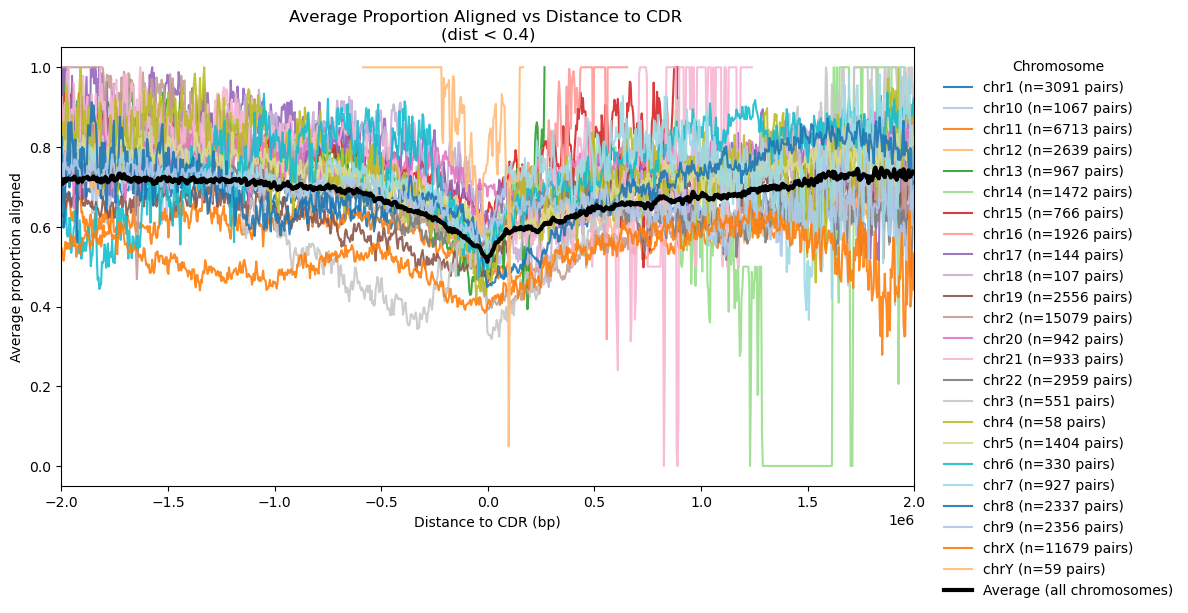

In [ ]:
# Filter for no CDR intersections found
df_plot = all_chr_df[all_chr_df["cdr_start"] != -1].copy()

# Take the first n_pairs per contig, then sum per chromosome
chr_n_pairs = (
    df_plot
    .groupby(["chr", "contig"], as_index=False)
    .agg(n_pairs_first=("n_pairs", "first"))
    .groupby("chr", as_index=False)
    .agg(n_pairs_sum=("n_pairs_first", "sum"))
)

# Convert to dict for easy lookup
chr_to_n_pairs = dict(
    zip(chr_n_pairs["chr"], chr_n_pairs["n_pairs_sum"])
)

# Calculate number of unique contigs
num_unique_contigs = df_plot["contig"].nunique()

# Determine dynamic range from data
min_dist = -2_000_000
max_dist = 2_000_000
print(f"Distance range: {min_dist} to {max_dist}")

# Define bins dynamically
num_bins = 1000
bins = np.linspace(min_dist, max_dist, num_bins + 1)

# Bin the distances
df_plot["bin"] = pd.cut(
    df_plot["dist_to_cdr"],
    bins=bins,
    include_lowest=True
)

# Aggregate per bin
bin_stats = (
    df_plot
    .groupby(["bin", "chr"],observed=True)
    .agg(
        prop_aligned_mean=("prop_aligned", "mean"),
        n_rows=("dist_to_cdr", "size")  # number of rows per bin
    )
    .reset_index()
)

# Bin centers for plotting
bin_stats["bin_center"] = bin_stats["bin"].apply(lambda x: x.mid)


# -----------------------------
# Plot all chromosomes AND average
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 6))

chromosomes = sorted(bin_stats["chr"].unique())
cmap = plt.get_cmap("tab20")

# Plot each chromosome as before
for i, chrom in enumerate(chromosomes):
    chrom_data = bin_stats[bin_stats["chr"] == chrom]

    n_pairs_sum = chr_to_n_pairs.get(chrom, 0)

    ax.plot(
        chrom_data["bin_center"],
        chrom_data["prop_aligned_mean"],
        label=f"{chrom} ({n_pairs_sum} pairs)",
        color=cmap(i % cmap.N),
        linewidth=1.5,
        alpha=0.9
    )

# -----------------------------
# Compute the average across all chromosomes
# -----------------------------
bin_stats_all = (
    df_plot
    .groupby("bin", observed=True)
    .agg(prop_aligned_mean=("prop_aligned", "mean"))
    .reset_index()
)

bin_stats_all["bin_center"] = bin_stats_all["bin"].apply(lambda x: x.mid)

# Plot the average line in bold black
ax.plot(
    bin_stats_all["bin_center"],
    bin_stats_all["prop_aligned_mean"],
    color="black",
    linewidth=3,
    label="Average (all chromosomes)"
)

# -----------------------------
# Axes and legend
# -----------------------------
ax.set_xlabel("Distance to CDR (bp)")
ax.set_ylabel("Average proportion aligned")
ax.set_xlim(min_dist, max_dist)

ax.legend(
    title="Chromosome",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False
)

plt.title("Average Proportion Aligned vs Distance to CDR \n(dist < 0.4)")

fig.tight_layout()
plt.show()


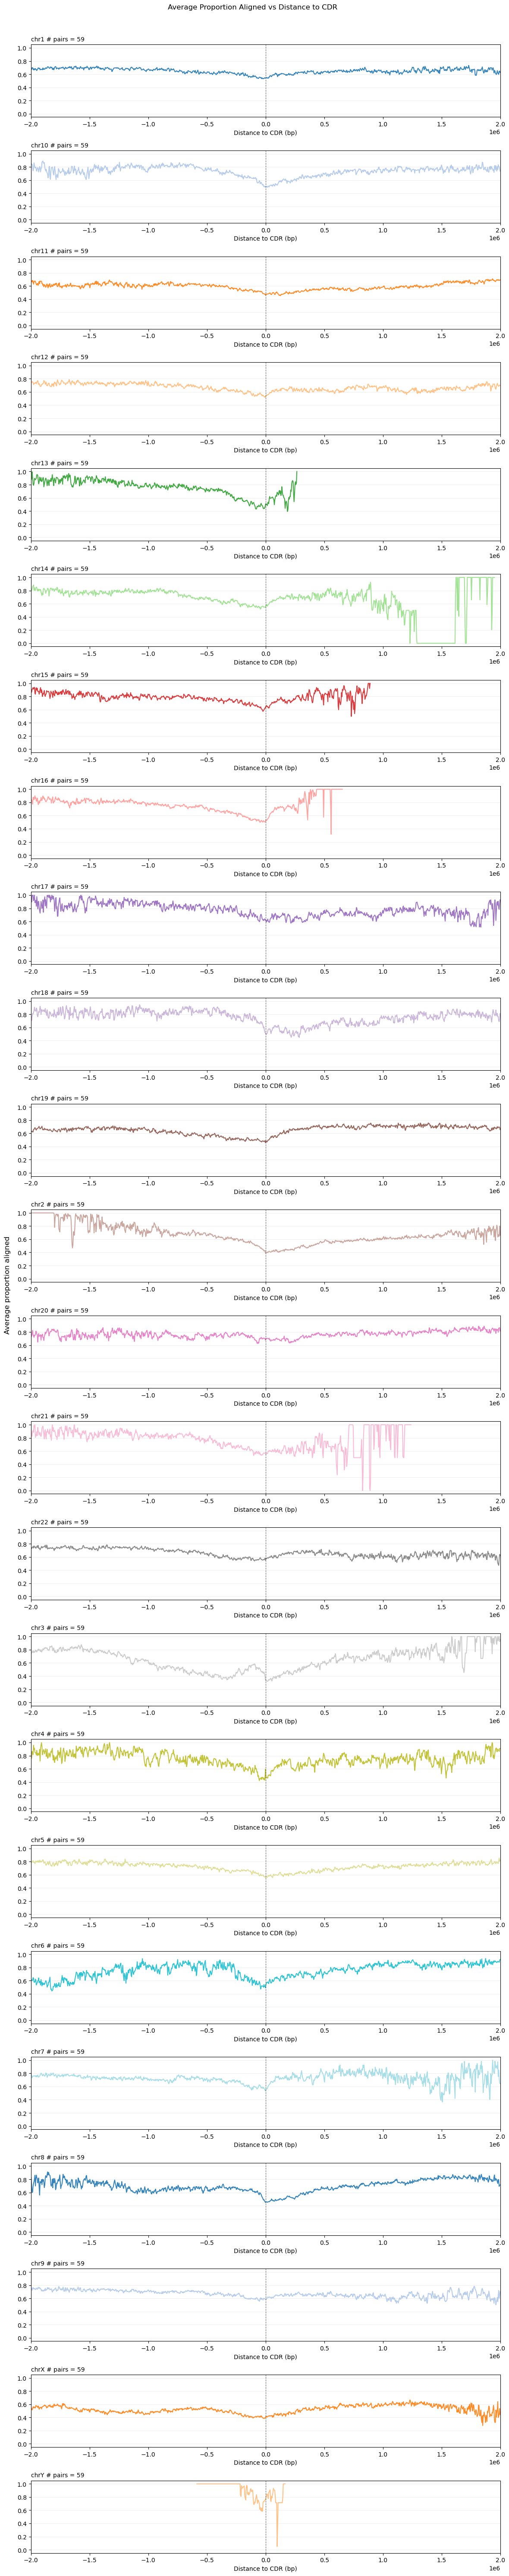

In [ ]:
# -----------------------------
# Plot: one panel per chromosome
# -----------------------------
chromosomes = sorted(bin_stats["chr"].unique())
n_chr = len(chromosomes)

fig, axes = plt.subplots(
    nrows=n_chr,
    ncols=1,
    figsize=(12, 2.5 * n_chr),
    sharex=True,
    sharey=True
)

# Handle single chromosome case
if n_chr == 1:
    axes = [axes]

cmap = plt.get_cmap("tab20")

for i, (ax, chrom) in enumerate(zip(axes, chromosomes)):
    chrom_data = bin_stats[bin_stats["chr"] == chrom]

    ax.plot(
        chrom_data["bin_center"],
        chrom_data["prop_aligned_mean"],
        color=cmap(i % cmap.N),
        linewidth=1.5,
        alpha=0.9
    )

    ax.set_title(f"{chrom} ({n_pairs_sum} pairs)", loc="left", fontsize=10)
    ax.axvline(0, color="black", linestyle="--", linewidth=0.8, alpha=0.6)
    ax.grid(True, axis="y", alpha=0.2)

    # Force x-axis tick labels on every subplot
    ax.tick_params(axis="x", labelbottom=True)

# Labels
for ax in axes:
    ax.set_xlabel("Distance to CDR (bp)")

fig.supylabel("Average proportion aligned")

axes[-1].set_xlim(min_dist, max_dist)

plt.suptitle(
    "Average Proportion Aligned vs Distance to CDR",
    y=0.995
)

fig.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


### All chromosomes, distance < 0.2

In [37]:
chromosomes = [
    "chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10",
    "chr11","chr12","chr13","chr14","chr15","chr16","chr17","chr18","chr19",
    "chr20","chr21","chr22","chrX","chrY"
]

base_dir = "/private/groups/patenlab/mira/centrolign/analysis/alignability/windowed_align_beds_50bp_d0.2_asm_coords"

dfs=[]
for chr_name in chromosomes:

    path = f"{base_dir}/{chr_name}/CDR_distance"
    df = read_bedtools_subset(path)
    df["chr"]=chr_name

    dfs.append(df)

all_chr_df_0_2=pd.concat(dfs, ignore_index=True)
all_chr_df_0_2.head()

,contig,start,end,prop_aligned,n_pairs,cdr_start,dist_to_cdr,source_file,chr
0,HG01071#2#CM089127.1,121718753,121718803,1.0,2,123033148,1314346,HG01071.2.windowed_alignment.CDR_dist.bed,chr1
1,HG01071#2#CM089127.1,121718803,121718853,1.0,2,123033148,1314296,HG01071.2.windowed_alignment.CDR_dist.bed,chr1
2,HG01071#2#CM089127.1,121718853,121718903,1.0,2,123033148,1314246,HG01071.2.windowed_alignment.CDR_dist.bed,chr1
3,HG01071#2#CM089127.1,121718903,121718953,1.0,2,123033148,1314196,HG01071.2.windowed_alignment.CDR_dist.bed,chr1
4,HG01071#2#CM089127.1,121718953,121719003,1.0,2,123033148,1314146,HG01071.2.windowed_alignment.CDR_dist.bed,chr1


Distance range: -2000000 to 2000000


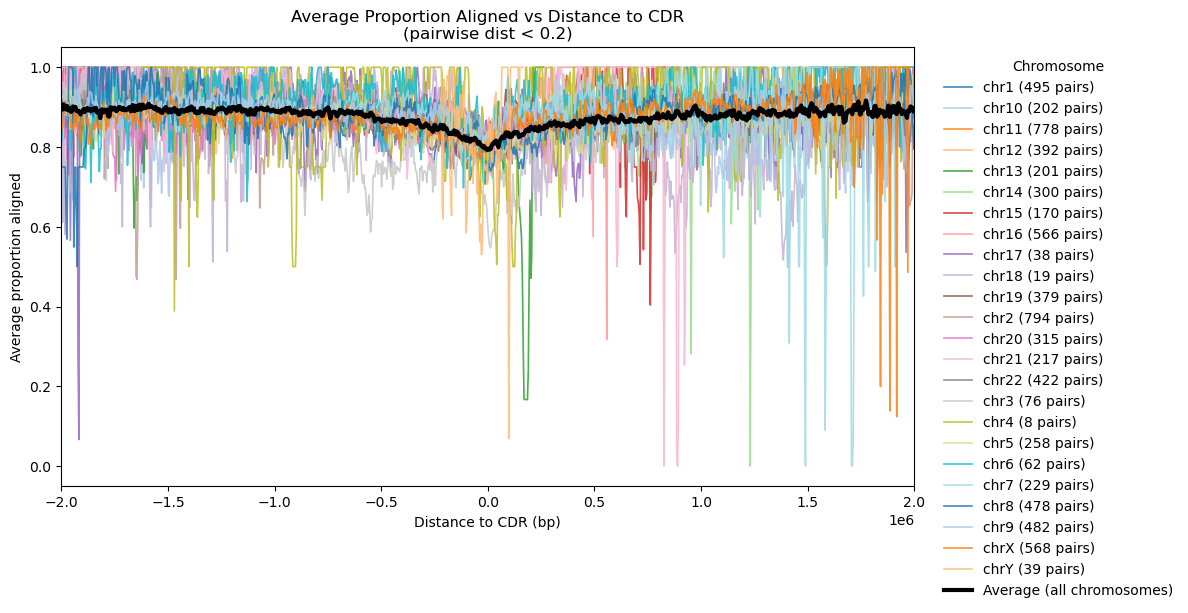

In [38]:
# Filter for no CDR intersections found
df_plot = all_chr_df_0_2[all_chr_df_0_2["cdr_start"] != -1].copy()

# Take the first n_pairs per contig, then sum per chromosome
chr_n_pairs = (
    df_plot
    .groupby(["chr", "contig"], as_index=False)
    .agg(n_pairs_first=("n_pairs", "first"))
    .groupby("chr", as_index=False)
    .agg(n_pairs_sum=("n_pairs_first", "sum"))
)

# Convert to dict for easy lookup
chr_to_n_pairs = dict(
    zip(chr_n_pairs["chr"], chr_n_pairs["n_pairs_sum"])
)

# Calculate number of unique contigs
num_unique_contigs = df_plot["contig"].nunique()

# Determine dynamic range from data
min_dist = -2_000_000
max_dist = 2_000_000
print(f"Distance range: {min_dist} to {max_dist}")

# Define bins dynamically
num_bins = 1000
bins = np.linspace(min_dist, max_dist, num_bins + 1)

# Bin the distances
df_plot["bin"] = pd.cut(
    df_plot["dist_to_cdr"],
    bins=bins,
    include_lowest=True
)

# Aggregate per bin
bin_stats = (
    df_plot
    .groupby(["bin", "chr"],observed=True)
    .agg(
        prop_aligned_mean=("prop_aligned", "mean"),
        n_rows=("dist_to_cdr", "size")  # number of rows per bin
    )
    .reset_index()
)

# Bin centers for plotting
bin_stats["bin_center"] = bin_stats["bin"].apply(lambda x: x.mid)


# -----------------------------
# Plot all chromosomes AND average
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 6))

chromosomes = sorted(bin_stats["chr"].unique())
cmap = plt.get_cmap("tab20")

# Plot each chromosome as before
for i, chrom in enumerate(chromosomes):
    chrom_data = bin_stats[bin_stats["chr"] == chrom]

    n_pairs_sum = chr_to_n_pairs.get(chrom, 0)

    ax.plot(
        chrom_data["bin_center"],
        chrom_data["prop_aligned_mean"],
        label=f"{chrom} ({n_pairs_sum} pairs)",
        color=cmap(i % cmap.N),
        linewidth=1.2,
        alpha=0.85
    )


# -----------------------------
# Compute the average across all chromosomes
# -----------------------------
bin_stats_all = (
    df_plot
    .groupby("bin", observed=True)
    .agg(prop_aligned_mean=("prop_aligned", "mean"))
    .reset_index()
)

bin_stats_all["bin_center"] = bin_stats_all["bin"].apply(lambda x: x.mid)

# Plot the average line in bold black
ax.plot(
    bin_stats_all["bin_center"],
    bin_stats_all["prop_aligned_mean"],
    color="black",
    linewidth=3,
    label="Average (all chromosomes)"
)

# -----------------------------
# Axes and legend
# -----------------------------
ax.set_xlabel("Distance to CDR (bp)")
ax.set_ylabel("Average proportion aligned")
ax.set_xlim(min_dist, max_dist)

ax.legend(
    title="Chromosome",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False
)

plt.title("Average Proportion Aligned vs Distance to CDR\n(pairwise dist < 0.2)")

fig.tight_layout()
plt.show()


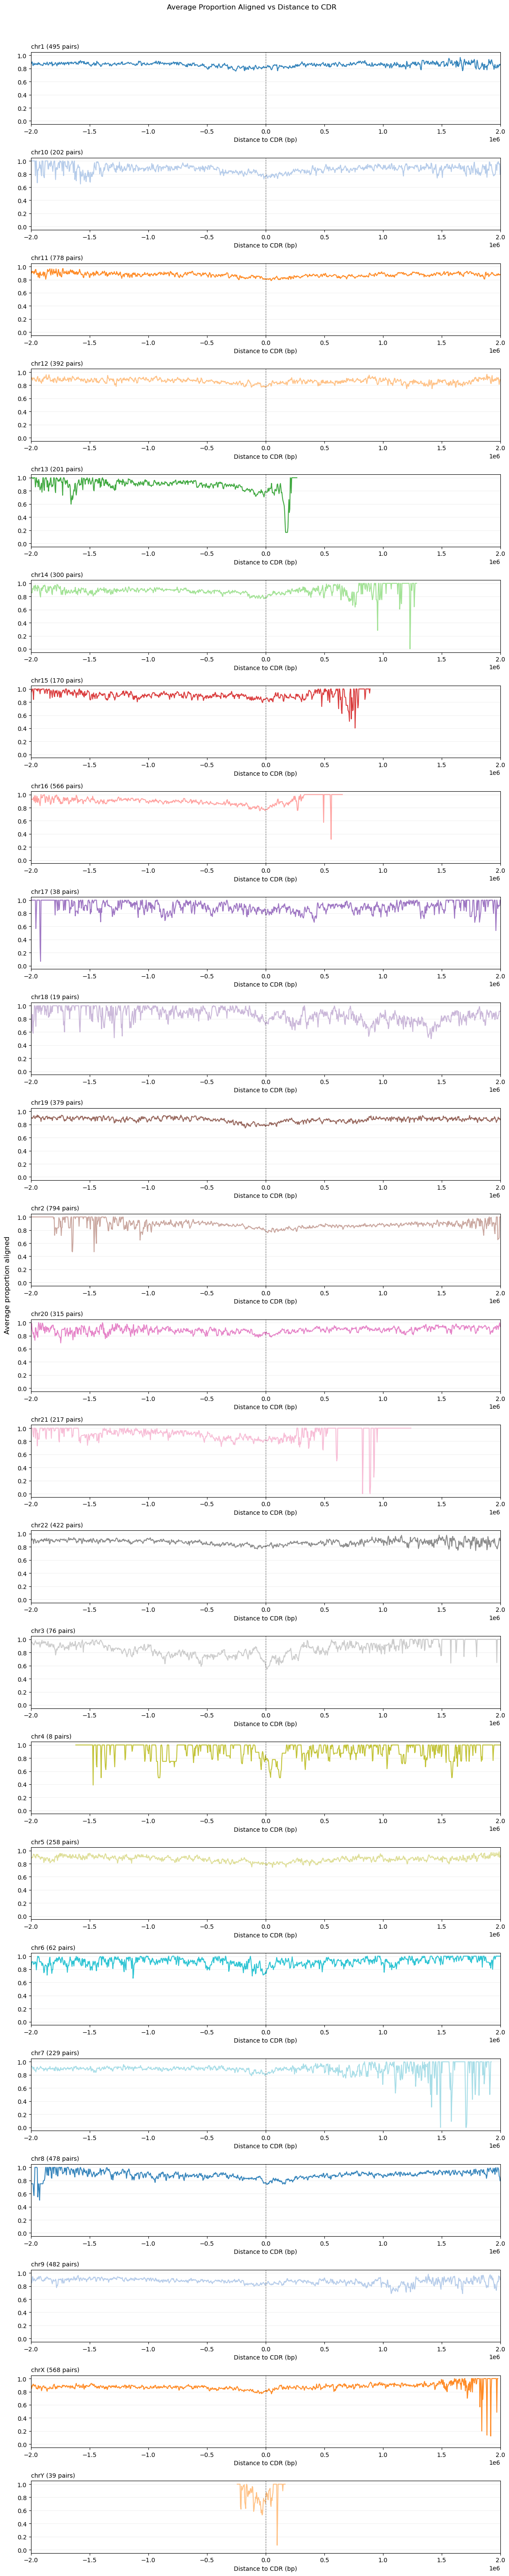

In [39]:
# -----------------------------
# Plot: one panel per chromosome
# -----------------------------
chromosomes = sorted(bin_stats["chr"].unique())
n_chr = len(chromosomes)

fig, axes = plt.subplots(
    nrows=n_chr,
    ncols=1,
    figsize=(12, 2.5 * n_chr),
    sharex=True,
    sharey=True
)

# Optionally exclude dist=0 bin for secondary axis
zero_bin_mask = bin_stats["bin"].apply(lambda x: x.left <= 0 <= x.right)
bin_stats.loc[zero_bin_mask, "n_rows"] = np.nan


# Handle single chromosome case
if n_chr == 1:
    axes = [axes]

cmap = plt.get_cmap("tab20")

for i, (ax, chrom) in enumerate(zip(axes, chromosomes)):
    chrom_data = bin_stats[bin_stats["chr"] == chrom]

    n_pairs_sum = chr_to_n_pairs.get(chrom, 0)

    ax.plot(
        chrom_data["bin_center"],
        chrom_data["prop_aligned_mean"],
        color=cmap(i % cmap.N),
        linewidth=1.5,
        alpha=0.9
    )

    ax.set_title(f"{chrom} ({n_pairs_sum} pairs)", loc="left", fontsize=10)
    ax.axvline(0, color="black", linestyle="--", linewidth=0.8, alpha=0.6)
    ax.grid(True, axis="y", alpha=0.2)

    # Force x-axis tick labels on every subplot
    ax.tick_params(axis="x", labelbottom=True)

# Labels
for ax in axes:
    ax.set_xlabel("Distance to CDR (bp)")

fig.supylabel("Average proportion aligned")

axes[-1].set_xlim(min_dist, max_dist)

plt.suptitle(
    "Average Proportion Aligned vs Distance to CDR \n",
    y=0.995
)

fig.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()